# Data processing

In [70]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.functional as F
import os
import sklearn

from sklearn.model_selection import train_test_split

In [71]:
default_df = pd.read_csv("data.csv", sep=';')
one_hot = pd.get_dummies(default_df['genre'])
one_hot_df = default_df.drop('genre', axis = 1)
one_hot_df = one_hot_df.join(one_hot)

one_hot_df.sum(axis=0, numeric_only=True)

Action         243
Adventure      244
Animation      243
Biography      247
Comedy         244
Crime          243
Documentary    171
Drama          244
Family         243
Fantasy        241
Film-Noir      241
History        248
Horror         243
Music          246
Musical        245
Mystery        242
Romance        193
Sci-Fi         198
Short          196
Sport          190
Superhero      195
Thriller       166
War            111
Western        124
dtype: int64

In [72]:
one_hot_df.head(20)

,title,description,img_link,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western
0,Black Panther: Wakanda Forever,The people of Wakanda fight to protect their h...,Action_01.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Andor,Prequel series to Star Wars' 'Rogue One'. In a...,Action_02.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Black Adam,"Nearly 5,000 years after he was bestowed with ...",Action_03.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,House of the Dragon,An internal succession war within House Targar...,Action_04.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Warrior Nun,"After waking up in a morgue, an orphaned teen ...",Action_05.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Game of Thrones,Nine noble families fight for control over the...,Action_06.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Enola Holmes 2,"Now a detective-for-hire, Enola Holmes takes o...",Action_07.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,All Quiet on the Western Front,A young German soldier's terrifying experience...,Action_08.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Poker Face,A tech billionaire hosts a high-stakes poker g...,Action_09.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Black Panther,"T'Challa, heir to the hidden but advanced king...",Action_010.jpg,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
target_genres = [
'Action',
'Adventure',
'Animation',
'Biography',
'Comedy', 'Crime', 'Documentary', 'Drama',
'Family', 'Fantasy', 'Film-Noir', 'History',
'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
'Sci-Fi', 'Short', 'Sport', 'Superhero', 'Thriller', 'War', 'Western'
]
num_of_genres = len(target_genres)
len(target_genres)

24

In [74]:
X, y = one_hot_df[['title', 'description', 'img_link']], one_hot_df[target_genres]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
assert not (y_train.mean() - y_test.mean() > 0.05).any() # Check difference in distribution below 1$
assert not (y_train.mean() == 0).any() # Check there is examples of each class
assert not (y_test.mean() == 0).any()

In [77]:
bce_weights = torch.tensor(1.0 / y_train.mean().values)
bce_weights

tensor([21.1168, 22.1277, 22.3656, 20.3922, 21.7801, 21.4433, 30.1449, 21.0101,
        21.8947, 21.1168, 20.5941, 21.5544, 21.4433, 20.9045, 22.2460, 22.4865,
        27.5497, 26.8387, 25.3659, 25.2121, 26.1635, 30.3650, 50.1205, 40.3883],
       dtype=torch.float64)

# Prediction

In [78]:
import typing
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [79]:
class FilmPreditor(pl.LightningModule):
  def __init__(self, predictor: nn.Module, criterion: nn.Module, optimizer_callback: typing.Callable):
    super().__init__()
    self.predictor = predictor
    self.criterion = criterion
    self.optimizer_callback = optimizer_callback
  
  def forward(self, x):
    probs = self.predictor(x)
    return probs
  
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    preds = self.predictor(x)
    loss = self.criterion(preds, y.float())
    self.log('train_loss', loss)
    return loss
  
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    preds = self.predictor(x)
    loss = self.criterion(preds, y.float())
    self.log('val_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = self.optimizer_callback(self.predictor.parameters())
    return optimizer

## Visual predictor

In [80]:
class FilmCVDataset(Dataset):
  def __init__(self, 
               meta_df: pd.DataFrame, 
               target_df: pd.DataFrame, 
               image_folder: str, 
               transformation: typing.Optional[typing.Callable]=None,
               is_inference: bool=False):
    self.folder = image_folder
    self.df = meta_df
    self.y = target_df
    self.transform = transformation
    self.is_inference=is_inference
  
  def __getitem__(self, idx: int):
    img_name  = self.df.iloc[idx]['img_link']
    image = torchvision.io.read_image(self.folder + "/" + str(img_name), mode=torchvision.io.ImageReadMode.RGB)

    if self.transform is not None:
      image = self.transform(image)

    if self.is_inference:
      return image

    target = torch.tensor(self.y.iloc[idx].values)
    return image, target
  
  def __len__(self):
    return len(self.df)

In [81]:
img_transformation = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [82]:
img_folder = "./images"

train_dl = DataLoader(FilmCVDataset(X_train, y_train, img_folder, img_transformation), batch_size=128, shuffle=True)
test_dl = DataLoader(FilmCVDataset(X_test, y_test, img_folder, img_transformation), batch_size=64, shuffle=False)
predict_dl = DataLoader(FilmCVDataset(X_test, y_test, img_folder, img_transformation, is_inference=True), batch_size=64, shuffle=False)

In [83]:
class VisualModel(nn.Module):
  def __init__(self, n_classes=num_of_genres):
    super(VisualModel, self).__init__()
    self.feature_extractor = torchvision.models.resnet34()
    self.model = nn.Sequential(
        nn.ReLU(inplace=True),
        nn.Linear(1000, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, n_classes),
        nn.Sigmoid(),
    )
    self.feature_extractor.requires_grad_(False)
  
  def forward(self, x):
    self.feature_extractor.eval()
    with torch.no_grad():
      x = self.feature_extractor(x)
    return self.model(x)

In [84]:
m = VisualModel()
visual_predictor = FilmPreditor(m, torch.nn.BCELoss(weight=bce_weights), lambda x: torch.optim.Adam(x, lr=0.0001))

In [88]:
trainer = pl.Trainer(max_epochs=8, limit_train_batches=15, limit_val_batches=1, accelerator='gpu')
trainer.fit(visual_predictor, train_dl, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | predictor | VisualModel | 22.1 M
1 | criterion | BCELoss     | 0     
------------------------------------------
262 K     Trainable params
21.8 M    Non-trainable params
22.1 M    Total params
88.240    Total estimated model params size (MB)


Epoch 7: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s, loss=4.25, v_num=6]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 16/16 [00:08<00:00,  1.80it/s, loss=4.25, v_num=6]


In [89]:
output = trainer.predict(visual_predictor, dataloaders=predict_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


In [90]:
output_formated = []
y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())
    output_formated.append(output[i][j].numpy())

In [91]:
output_formated = np.array(output_formated)
y_target = np.array(y_target)

y_target.shape, output_formated.shape

((1041, 24), (1041, 24))

## Metrics calculation

In [51]:
from sklearn import metrics

In [92]:
def compute_metrics(y_true, y_pred):
  f1 = metrics.f1_score(y_true, y_pred, average=None)
  recall = metrics.recall_score(y_true, y_pred, average=None)
  precision = metrics.precision_score(y_true, y_pred, average=None)

  return {"f1": f1, "recall": recall, "precision": precision, "f1_macro": f1.mean(), "recall_macro": recall.mean(), "precision_macro": precision.mean()}

In [109]:
y_pred = output_formated.copy()
t = 0.07
y_pred[y_pred > t] = 1
y_pred[y_pred <= t] = 0
metrics_dict = compute_metrics(y_target, y_pred)
metrics_dict

{'f1': array([0.04232804, 0.08376963, 0.09665428, 0.1147541 , 0.04102564,
        0.03125   , 0.06956522, 0.07619048, 0.0733945 , 0.08724832,
        0.03717472, 0.11764706, 0.13937282, 0.05964912, 0.08080808,
        0.17777778, 0.        , 0.05660377, 0.0952381 , 0.03773585,
        0.09876543, 0.        , 0.05882353, 0.        ]),
 'recall': array([0.08695652, 0.28571429, 0.22807018, 0.3255814 , 0.0754717 ,
        0.02040816, 0.12121212, 0.08695652, 0.1509434 , 0.29545455,
        0.12820513, 0.14545455, 0.40816327, 0.36170213, 0.20689655,
        0.21052632, 0.        , 0.13953488, 0.1875    , 0.08      ,
        0.11111111, 0.        , 0.03571429, 0.        ]),
 'precision': array([0.02797203, 0.04907975, 0.06132075, 0.06965174, 0.02816901,
        0.06666667, 0.04878049, 0.06779661, 0.04848485, 0.0511811 ,
        0.02173913, 0.09876543, 0.08403361, 0.03250478, 0.05020921,
        0.15384615, 0.        , 0.03550296, 0.06382979, 0.02469136,
        0.08888889, 0.        , 0.16666

In [103]:
import pickle
pickle.dump(metrics, open('/content/drive/MyDrive/ITMO/IndustryML/LW2/metrics.pkl', 'wb'))

## Text predictor

In [110]:
from transformers import BertTokenizer, BertForSequenceClassification

In [125]:
class FilmTextDataset(Dataset):
  def __init__(self, 
               meta_df: pd.DataFrame, 
               target_df: pd.DataFrame,
               is_inference:bool=False):
    self.df = meta_df
    self.y = target_df
    self.tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
    #self.max_seq_len = int(self.df['title'].str.len().max() + self.df['short'].str.len().max() + 3)
    self.max_seq_len = 120
    self.is_inference=is_inference
  
  def __getitem__(self, idx: int):
    text  = str(self.df.iloc[idx]['title']) + ' # ' + str(self.df.iloc[idx]['description'])
    tokenized = self.tokenizer(text, max_length=self.max_seq_len, padding='max_length')
    target = torch.tensor(self.y.iloc[idx].values)
    if self.is_inference:
      return {k: torch.tensor(v) for k, v in tokenized.items()}

    return {k: torch.tensor(v) for k, v in tokenized.items()}, target
  
  def __len__(self):
    return len(self.df)

In [126]:
class TextModel(nn.Module):
  def __init__(self, n_classes=num_of_genres):
    super(TextModel, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", 
                                                              num_labels=n_classes,
                                                              ignore_mismatched_sizes=True)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    return self.sigmoid(self.bert(**x).logits)

In [150]:
train_dl = DataLoader(FilmTextDataset(X_train, y_train), batch_size=16, shuffle=True)
test_dl = DataLoader(FilmTextDataset(X_test, y_test), batch_size=32, shuffle=False)
predict_dl = DataLoader(FilmTextDataset(X_test, y_test, is_inference=True), batch_size=32, shuffle=False)

y_target = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    y_target.append(y_tar[j].numpy())

y_target = np.array(y_target)


In [151]:
m = TextModel()
text_predictor = FilmPreditor(m, torch.nn.BCELoss(), lambda x: torch.optim.Adam(x, lr=0.0001))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [153]:
trainer = pl.Trainer(max_epochs=3, val_check_interval=0.5, accelerator='gpu')
trainer.fit(text_predictor, train_dl, test_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | predictor | TextModel | 109 M 
1 | criterion | BCELoss   | 0     
----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.003   Total estimated model params size (MB)


Epoch 2: 100%|██████████| 326/326 [01:07<00:00,  4.83it/s, loss=0.174, v_num=10]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 326/326 [01:07<00:00,  4.83it/s, loss=0.174, v_num=10]


In [154]:
output = trainer.predict(text_predictor, dataloaders=predict_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 33/33 [00:03<00:00, 10.35it/s]


In [156]:
output_formated = []
for i, (_, y_tar) in enumerate(test_dl):
  for j in range(len(y_tar)):
    output_formated.append(output[i][j].numpy())
output_formated = np.array(output_formated)

In [157]:

y_target.shape, output_formated.shape

((1041, 24), (1041, 24))

## Metrics calculation

In [134]:
from sklearn import metrics

In [143]:
y_pred = output_formated.copy()
thr = 0.03
y_pred[y_pred > thr] = 1
y_pred[y_pred <= thr] = 0
metrics_dict = compute_metrics(y_target, y_pred)
metrics_dict

c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': array([0.08463661, 0.10209663, 0.10382514, 0.07933579, 0.09689214,
        0.11612903, 0.06443299, 0.08463661, 0.09689214, 0.08110599,
        0.07222222, 0.10036496, 0.08990826, 0.08639706, 0.1055505 ,
        0.10382514, 0.07756233, 0.07933579, 0.04661017, 0.04690432,
        0.06685237, 0.03921569, 0.        , 0.07142857]),
 'recall': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.18367347, 0.75757576, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.34375   , 1.        ,
        1.        , 0.06896552, 0.        , 0.04761905]),
 'precision': array([0.04418828, 0.05379443, 0.05475504, 0.04130644, 0.05091258,
        0.08490566, 0.03364738, 0.04418828, 0.05091258, 0.04226705,
        0.03746398, 0.05283381, 0.04707012, 0.0451489 , 0.05571566,
        0.05475504, 0.04034582, 0.04130644, 0.025     , 0.02401537,
        0.03458213, 0.02739726, 0.     

In [144]:
thrs = np.linspace(0, 1)

In [145]:
f1s = []
recalls = []
precisions = []
for t in thrs:
  y_pred = output_formated.copy()
  y_pred[y_pred > t] = 1
  y_pred[y_pred <= t] = 0
  metrics_dict = compute_metrics(y_target, y_pred)
  f1s.append(metrics_dict['f1_macro'])
  recalls.append(metrics_dict['recall_macro'])
  precisions.append(metrics_dict['precision_macro'])

c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vando\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\User

In [146]:
import matplotlib.pyplot as plt

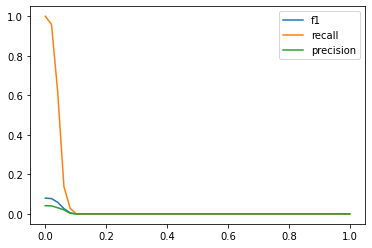

In [147]:
plt.plot(thrs, f1s, label='f1')
plt.plot(thrs, recalls, label='recall')
plt.plot(thrs, precisions, label='precision')
plt.legend()